In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [12]:
training_reviews = pd.read_excel('Sentiment Reviews.xlsx', sheet_name='Training')
training_reviews.head()

,Category,Text
0,Negative,Never again I have just come home from Rome an...
1,Negative,I am sure there are better options Front of th...
2,Negative,Avoid like the plague We got into Rome at abou...
3,Negative,Cheated see photos Hall way leading upstairs b...
4,Negative,Horrible DO NOT STAY HERE We stayed in this ho...


In [22]:
test_reviews = pd.read_excel('Sentiment Reviews.xlsx', sheet_name='Test')
test_reviews.head()

,Category,Text
0,Negative,1 Star Quality at 4 Star Rates If you are look...
1,Negative,Bad Location As it was said previously Claridg...
2,Negative,Small Sad and Smelly On arrival the hotel was ...
3,Negative,Do not Go I'm English been staying at hotels f...
4,Negative,shabby this hotel was one of the reccomendatio...


In [13]:
training_reviews['Category'].value_counts()

Negative    1083
Positive    1000
Name: Category, dtype: int64

In [14]:
training_reviews['Category'] = np.where(training_reviews['Category'] == 'Positive', 1, 0)

In [23]:
test_reviews['Category'] = np.where(test_reviews['Category'] == 'Positive', 1, 0)

In [15]:
training_reviews['Category'].value_counts()

0    1083
1    1000
Name: Category, dtype: int64

In [24]:
test_reviews['Category'].value_counts()

1    121
0    100
Name: Category, dtype: int64

In [16]:
sentences = training_reviews['Text'].to_numpy()
labels = training_reviews['Category'].to_numpy()

In [25]:
test_sentences = test_reviews['Text'].to_numpy()
test_labels = test_reviews['Category'].to_numpy()

In [17]:
vocab_size = 10000
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)


In [18]:
tokenizer.fit_on_texts(sentences)
print("Number of Documents: ", tokenizer.document_count)
print("Number of Words: ", tokenizer.num_words)

Number of Documents:  2083
Number of Words:  10000


In [19]:
tokenizer.word_counts

OrderedDict([('never', 328),
             ('again', 648),
             ('i', 5085),
             ('have', 1957),
             ('just', 1027),
             ('come', 161),
             ('home', 164),
             ('from', 2230),
             ('rome', 1778),
             ('and', 13324),
             ('four', 176),
             ('nights', 572),
             ('at', 3315),
             ('the', 26507),
             ('hotel', 6502),
             ('locarno', 25),
             ('only', 1017),
             ('good', 1311),
             ('thing', 175),
             ('was', 8305),
             ('its', 301),
             ('location', 1254),
             ('breakfast', 1454),
             ('found', 391),
             ('terribly', 12),
             ('shabby', 40),
             ('rundown', 4),
             ('rooms', 1215),
             ('saw', 80),
             ('2', 561),
             ('were', 3502),
             ('dark', 101),
             ('tiny', 183),
             ('with', 2792),
             ('smal

In [20]:
train_sequences = tokenizer.texts_to_sequences(sentences)
print(train_sequences[0])

[171, 79, 11, 30, 54, 320, 312, 28, 33, 3, 294, 90, 18, 2, 9, 1361, 2, 57, 45, 299, 6, 181, 47, 3, 2, 42, 11, 135, 2, 9, 2146, 993, 3, 3954, 2, 48, 11, 580, 95, 17, 492, 3, 285, 24, 70, 399, 3, 349, 274, 2, 994, 6, 41, 70, 21, 2, 3955, 55, 13, 959, 3, 2, 1324, 484, 2147, 10, 2, 1803, 6, 23, 345, 7, 27, 5, 240, 4, 7219, 5, 342, 8, 108, 29, 2, 35, 18, 2, 130, 107, 6, 13, 23, 84, 3, 23, 4511, 29, 6, 259, 2253, 58, 19, 9]


In [21]:
sequence_length = 200
train_padded = pad_sequences(train_sequences, maxlen=sequence_length, padding='post', truncating='post')


In [26]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=sequence_length, padding='post', truncating='post')

In [27]:
model = Sequential()

In [28]:
embedding_dim = 16
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))

In [29]:
lstm_out = 32
model.add(Bidirectional(LSTM(lstm_out)))

In [30]:
model.add(Dense(10, activation='relu'))

In [31]:
model.add(Dense(1, activation='sigmoid'))

In [32]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 173,205
Trainable params: 173,205
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
checkpoint_filepath = os.getcwd()
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
callbacks = [EarlyStopping(patience=2), model_checkpoint_callback]

In [42]:
tf.config.run_functions_eagerly(True)

In [43]:
history = model.fit(train_padded, labels, epochs=10, validation_data=(test_padded, test_labels), callbacks=callbacks)

Epoch 1/10


C:\Users\Divyanshu\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


66/66 [==============================] - ETA: 0s - loss: 0.6824 - accuracy: 0.5305

INFO:tensorflow:Assets written to: D:\ST_NLP\assets


INFO:tensorflow:Assets written to: D:\ST_NLP\assets


66/66 [==============================] - 83s 1s/step - loss: 0.6824 - accuracy: 0.5305 - val_loss: 0.6688 - val_accuracy: 0.8643
Epoch 2/10
66/66 [==============================] - ETA: 0s - loss: 0.5884 - accuracy: 0.8243

INFO:tensorflow:Assets written to: D:\ST_NLP\assets


INFO:tensorflow:Assets written to: D:\ST_NLP\assets


66/66 [==============================] - 74s 1s/step - loss: 0.5884 - accuracy: 0.8243 - val_loss: 0.4664 - val_accuracy: 0.8552
Epoch 3/10
66/66 [==============================] - ETA: 0s - loss: 0.2552 - accuracy: 0.9227

INFO:tensorflow:Assets written to: D:\ST_NLP\assets


INFO:tensorflow:Assets written to: D:\ST_NLP\assets


66/66 [==============================] - 71s 1s/step - loss: 0.2552 - accuracy: 0.9227 - val_loss: 0.1873 - val_accuracy: 0.9186
Epoch 4/10
66/66 [==============================] - ETA: 0s - loss: 0.0887 - accuracy: 0.9683

INFO:tensorflow:Assets written to: D:\ST_NLP\assets


INFO:tensorflow:Assets written to: D:\ST_NLP\assets


66/66 [==============================] - 70s 1s/step - loss: 0.0887 - accuracy: 0.9683 - val_loss: 0.1028 - val_accuracy: 0.9593
Epoch 5/10
66/66 [==============================] - 47s 706ms/step - loss: 0.0330 - accuracy: 0.9914 - val_loss: 0.1235 - val_accuracy: 0.9457
Epoch 6/10
66/66 [==============================] - 46s 691ms/step - loss: 0.0179 - accuracy: 0.9942 - val_loss: 0.1043 - val_accuracy: 0.9729


In [44]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

       loss  accuracy  val_loss  val_accuracy
0  0.682416  0.530485  0.668848      0.864253
1  0.588398  0.824292  0.466422      0.855204
2  0.255180  0.922708  0.187297      0.918552
3  0.088714  0.968315  0.102758      0.959276
4  0.032999  0.991359  0.123479      0.945701
5  0.017882  0.994239  0.104320      0.972851


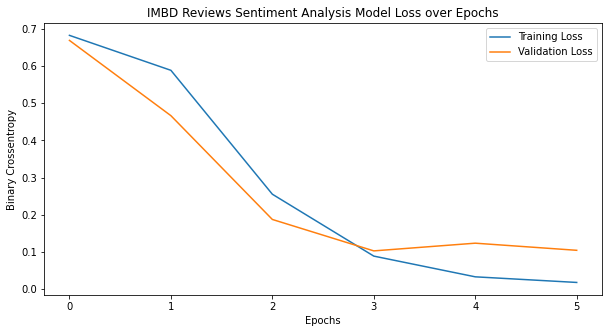

In [45]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('IMBD Reviews Sentiment Analysis Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

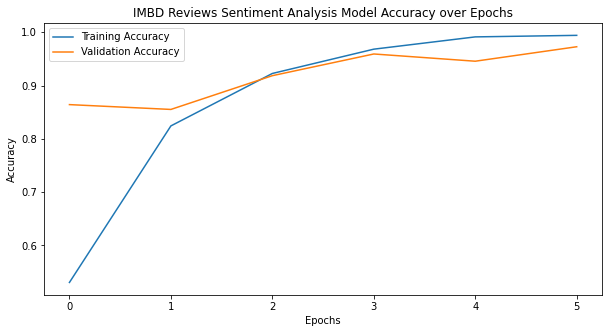

In [46]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.accuracy)
plt.plot(metrics_df.index, metrics_df.val_accuracy)
plt.title('IMBD Reviews Sentiment Analysis Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()